In [ ]:
import os, json, time
from pathlib import Path
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import seaborn as sns

# Kaggle download & prepare
kaggle_json_path = "/content/kaggle.json"  # upload here in Colab

if os.path.exists(kaggle_json_path):
    kaggle_dir = os.path.expanduser("~/.kaggle")
    os.makedirs(kaggle_dir, exist_ok=True)
    with open(kaggle_json_path, "r") as f:
        creds = json.load(f)
    with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
        json.dump(creds, f)
    os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)
else:
    raise FileNotFoundError("Please upload your kaggle.json to /content/kaggle.json before running.")

dataset_folder = "/content/melanoma_dataset"
os.makedirs(dataset_folder, exist_ok=True)

print("Downloading Kaggle dataset (may take a few minutes)...")
os.system(f'kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images -p "{dataset_folder}" --unzip')

# Try to find the extracted folder robustly
candidates = [p for p in Path(dataset_folder).iterdir() if p.is_dir()]
root = None
for c in candidates:
    names = [x.name.lower() for x in c.iterdir() if x.exists()] if c.exists() else []
    if any(k in names for k in ("train","test","validation")) or any(k in names for k in ("benign","malignant")):
        root = str(c)
        break
if root is None:
    # fallback to dataset_folder
    root = dataset_folder

print("Using dataset root:", root)
print("Root contents:", os.listdir(root)[:20])

# Define expected train/val/test dirs if present
train_dir = os.path.join(root, "train")
val_dir   = os.path.join(root, "validation")
test_dir  = os.path.join(root, "test")

Using dataset root: /content/melanoma_dataset/melanoma_cancer_dataset
Root contents: ['test', 'train']


In [ ]:
# Transforms & Dataloaders
IMG_SIZE = 224
BATCH = 16
NUM_WORKERS = 2

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Build datasets depending on folder layout
if os.path.isdir(train_dir) and os.path.isdir(test_dir):
    print("Detected explicit train/test folders; building datasets from them.")
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)
    if os.path.isdir(val_dir):
        val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
    else:
        # split train into train+val (85/15)
        total = len(train_dataset)
        val_size = int(0.15 * total)
        train_size = total - val_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        train_dataset.dataset.transform = train_transform
        val_dataset.dataset.transform = val_transform
else:
    # assume root directly contains class folders (benign, malignant)
    print("No train/test folders found — creating train/val/test splits from class folders.")
    full_dataset = datasets.ImageFolder(root, transform=train_transform)
    total = len(full_dataset)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)
    test_size = total - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform

print("Dataset sizes -> Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))
# Class counts (best-effort)
try:
    if hasattr(train_dataset, "dataset"):
        base = train_dataset.dataset
    else:
        base = train_dataset
    class_counts = Counter([y for _, y in base.samples])
    print("Train class counts:", class_counts)
except Exception:
    pass

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Detected explicit train/test folders; building datasets from them.
Dataset sizes -> Train: 8165 Val: 1440 Test: 1000
Train class counts: Counter({0: 5000, 1: 4605})


In [ ]:
# Model: Pretrained ResNet50 (transfer learning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze base parameters first
for param in model.parameters():
    param.requires_grad = False

# Replace head for binary classification (no sigmoid here; we'll use BCEWithLogitsLoss)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 1)  # single logit
)
model = model.to(device)

# Loss and optimizer (only head params are trainable initially)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)

Device: cuda


In [ ]:
# Training loop with early stopping and staged fine-tuning
EPOCHS_STAGE1 = 6   # train head only
EPOCHS_STAGE2 = 12  # unfreeze & fine-tune some layers
PATIENCE = 5

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            all_logits.append(outputs.detach().cpu().numpy())
            all_targets.append(labels.detach().cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    all_logits = np.vstack(all_logits).ravel()
    all_targets = np.vstack(all_targets).ravel().astype(int)
    return avg_loss, all_logits, all_targets

best_val_loss = float('inf')
patience_counter = 0
history = {"train_loss":[], "val_loss":[]}

print("=== Stage 1: Training head only ===")
for epoch in range(EPOCHS_STAGE1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, _, _ = eval_one_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    print(f"[Stage1] Epoch {epoch+1}/{EPOCHS_STAGE1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} (time {time.time()-t0:.1f}s)")
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_resnet50_stage1.pth")
        print("  -> Saved best model (stage1)")
    else:
        patience_counter += 1
        print(f"  -> No improvement: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("  -> Early stopping stage1")
            break

# Load best head model
if os.path.exists("best_resnet50_stage1.pth"):
    model.load_state_dict(torch.load("best_resnet50_stage1.pth"))

# ---------------------------
# Unfreeze last layers (fine-tune)
# ---------------------------
print("\n=== Stage 2: Fine-tuning last layers (layer3 & layer4) ===")
# Unfreeze layer3 and layer4
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True

# Re-create optimizer for all unfrozen params (lower lr)
params_to_optimize = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params_to_optimize, lr=1e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)

best_val_loss_stage2 = float('inf')
patience_counter = 0

for epoch in range(EPOCHS_STAGE2):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, _, _ = eval_one_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    print(f"[Stage2] Epoch {epoch+1}/{EPOCHS_STAGE2} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} (time {time.time()-t0:.1f}s)")

    if val_loss < best_val_loss_stage2:
        best_val_loss_stage2 = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_resnet50_finetuned.pth")
        print("  -> Saved best model (fine-tuned)")
    else:
        patience_counter += 1
        print(f"  -> No improvement: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("  -> Early stopping fine-tuning")
            break

# Load best fine-tuned model
if os.path.exists("best_resnet50_finetuned.pth"):
    model.load_state_dict(torch.load("best_resnet50_finetuned.pth"))

# Save final model
torch.save(model.state_dict(), "resnet50_melanoma_best.pth")
print("Saved final best model: resnet50_melanoma_best.pth")

=== Stage 1: Training head only ===
[Stage1] Epoch 1/6 - Train Loss: 0.2278 - Val Loss: 0.1664 (time 62.1s)
  -> Saved best model (stage1)
[Stage1] Epoch 2/6 - Train Loss: 0.1477 - Val Loss: 0.1891 (time 60.1s)
  -> No improvement: 1/5
[Stage1] Epoch 3/6 - Train Loss: 0.0915 - Val Loss: 0.1985 (time 59.8s)
  -> No improvement: 2/5
[Stage1] Epoch 4/6 - Train Loss: 0.0533 - Val Loss: 0.2063 (time 59.5s)
  -> No improvement: 3/5
[Stage1] Epoch 5/6 - Train Loss: 0.0371 - Val Loss: 0.2112 (time 60.4s)
  -> No improvement: 4/5
[Stage1] Epoch 6/6 - Train Loss: 0.0278 - Val Loss: 0.2420 (time 60.5s)
  -> No improvement: 5/5
  -> Early stopping stage1

=== Stage 2: Fine-tuning last layers (layer3 & layer4) ===
[Stage2] Epoch 1/12 - Train Loss: 0.1488 - Val Loss: 0.1709 (time 59.6s)
  -> Saved best model (fine-tuned)
[Stage2] Epoch 2/12 - Train Loss: 0.0916 - Val Loss: 0.1818 (time 59.5s)
  -> No improvement: 1/5
[Stage2] Epoch 3/12 - Train Loss: 0.0521 - Val Loss: 0.1989 (time 60.1s)
  -> No im


Validation metrics:
  Acc: 0.9292  AUC: 0.9813
              precision    recall  f1-score   support

      Benign       0.92      0.94      0.93       756
   Malignant       0.93      0.92      0.92       684

    accuracy                           0.93      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.93      0.93      0.93      1440



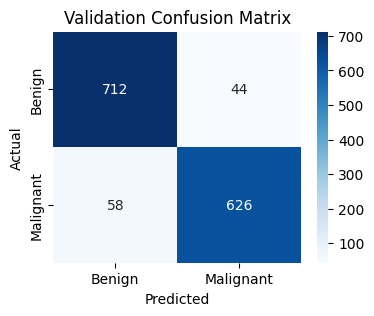


Test metrics:
  Acc: 0.9200  AUC: 0.9773
              precision    recall  f1-score   support

      Benign       0.90      0.94      0.92       500
   Malignant       0.94      0.90      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



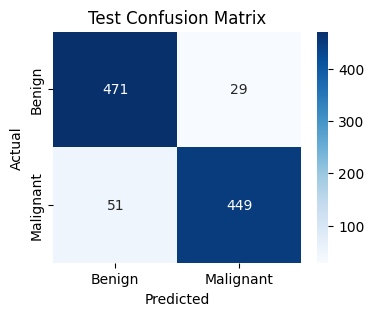

Saved evaluation_summary.csv


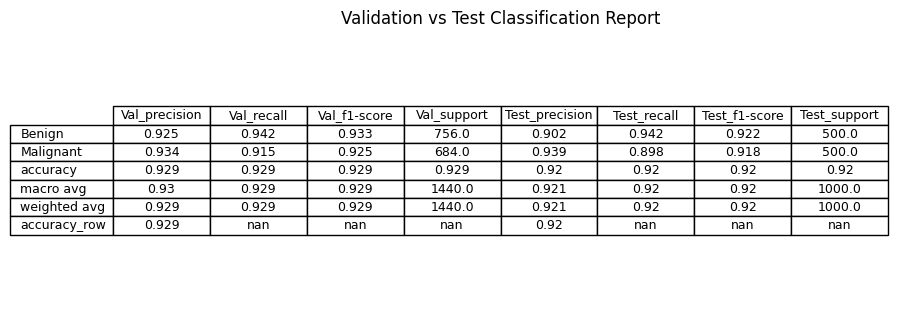

Saved evaluation_summary.png


In [ ]:
# Evaluation on validation & test sets
def preds_from_logits(logits):
    probs = 1.0 / (1.0 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    return probs, preds

# Validation
val_loss, val_logits, val_targets = eval_one_epoch(model, val_loader, criterion, device)
val_probs, val_preds = preds_from_logits(val_logits)
val_acc = (val_preds == val_targets).mean()
val_auc = roc_auc_score(val_targets, val_probs)
print("\nValidation metrics:")
print(f"  Acc: {val_acc:.4f}  AUC: {val_auc:.4f}")
print(classification_report(val_targets, val_preds, target_names=["Benign","Malignant"]))
cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign","Malignant"], yticklabels=["Benign","Malignant"])
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# Test
test_loss, test_logits, test_targets = eval_one_epoch(model, test_loader, criterion, device)
test_probs, test_preds = preds_from_logits(test_logits)
test_acc = (test_preds == test_targets).mean()
test_auc = roc_auc_score(test_targets, test_probs)
print("\nTest metrics:")
print(f"  Acc: {test_acc:.4f}  AUC: {test_auc:.4f}")
print(classification_report(test_targets, test_preds, target_names=["Benign","Malignant"]))
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign","Malignant"], yticklabels=["Benign","Malignant"])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# Save evaluation summary as CSV and PNG table
report_val = classification_report(val_targets, val_preds, target_names=["Benign","Malignant"], output_dict=True)
report_test = classification_report(test_targets, test_preds, target_names=["Benign","Malignant"], output_dict=True)
df_val = pd.DataFrame(report_val).transpose()
df_test = pd.DataFrame(report_test).transpose()

# Add accuracy & auc row
df_val.loc["accuracy_row"] = [val_acc, None, None, None]
df_test.loc["accuracy_row"] = [test_acc, None, None, None]

combined = pd.concat([df_val.add_prefix("Val_"), df_test.add_prefix("Test_")], axis=1)
combined.to_csv("evaluation_summary.csv", index=True)
print("Saved evaluation_summary.csv")

# Render table image
fig, ax = plt.subplots(figsize=(10, combined.shape[0]*0.35 + 1.5))
ax.axis('off')
tbl = ax.table(cellText=np.round(combined.fillna(np.nan).values, 3).astype(str), colLabels=combined.columns, rowLabels=combined.index, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1,1.1)
plt.title("Validation vs Test Classification Report")
plt.savefig("evaluation_summary.png", bbox_inches='tight', dpi=300)
plt.show()
print("Saved evaluation_summary.png")

In [ ]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


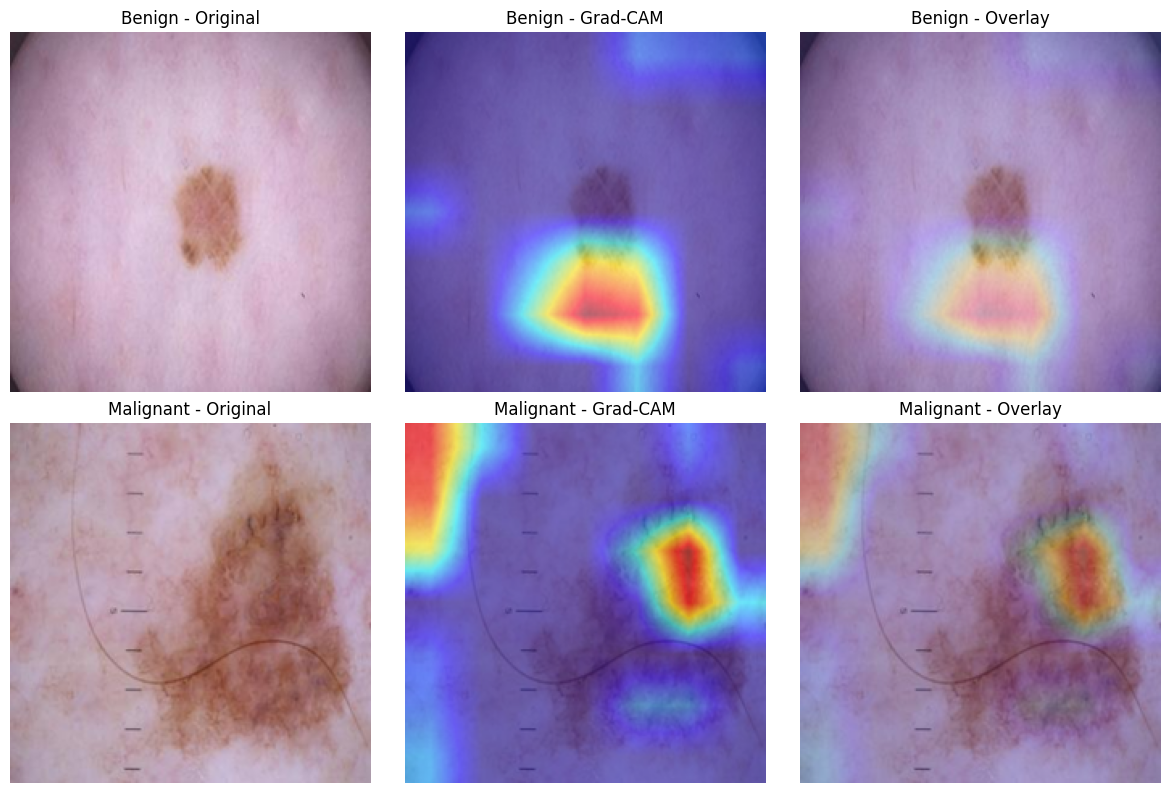

Saved Grad-CAM visualization to gradcam_benign_malignant.png
All done. Models and artifacts saved:
 - resnet50_melanoma_best.pth
 - evaluation_summary.csv
 - evaluation_summary.png


In [ ]:
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
except Exception as e:
    print("grad-cam not found. Please `pip install grad-cam` and re-run the Grad-CAM block.")
    raise e

# pick one benign and one malignant sample from test dataset if possible
def get_sample_paths_from_dataset(dataset, desired_label):
    # dataset may be a Subset
    base = dataset.dataset if hasattr(dataset, "dataset") else dataset
    samples = base.samples  # list of (path,label)
    for p, label in samples:
        if label == desired_label:
            return p
    return None

# Try find sample paths; fall back to train_dir
benign_path = get_sample_paths_from_dataset(test_dataset, 0) or get_sample_paths_from_dataset(train_dataset, 0)
malig_path  = get_sample_paths_from_dataset(test_dataset, 1) or get_sample_paths_from_dataset(train_dataset, 1)

if benign_path is None or malig_path is None:
    print("Could not find both sample paths for Grad-CAM — skipping Grad-CAM.")
else:
    target_layers = [model.layer4[-1].conv3]  # last conv block in ResNet50
    cam = GradCAM(model=model, target_layers=target_layers)

    def make_cam_image(img_path):
        rgb_img = np.float32(Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))) / 255.0
        input_tensor = preprocess_image(rgb_img, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        grayscale_cam = cam(input_tensor=input_tensor)[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        return rgb_img, visualization

    b_rgb, b_vis = make_cam_image(benign_path)
    m_rgb, m_vis = make_cam_image(malig_path)

    # Plot side-by-side
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes[0,0].imshow(b_rgb); axes[0,0].set_title("Benign - Original"); axes[0,0].axis("off")
    axes[0,1].imshow(b_vis); axes[0,1].set_title("Benign - Grad-CAM"); axes[0,1].axis("off")
    # overlay
    axes[0,2].imshow( (0.6*b_rgb + 0.4*(b_vis/255.0)) ); axes[0,2].set_title("Benign - Overlay"); axes[0,2].axis("off")

    axes[1,0].imshow(m_rgb); axes[1,0].set_title("Malignant - Original"); axes[1,0].axis("off")
    axes[1,1].imshow(m_vis); axes[1,1].set_title("Malignant - Grad-CAM"); axes[1,1].axis("off")
    axes[1,2].imshow( (0.6*m_rgb + 0.4*(m_vis/255.0)) ); axes[1,2].set_title("Malignant - Overlay"); axes[1,2].axis("off")

    plt.tight_layout()
    cam_out = "gradcam_benign_malignant.png"
    plt.savefig(cam_out, bbox_inches='tight', dpi=300)
    plt.show()
    print("Saved Grad-CAM visualization to", cam_out)

print("All done. Models and artifacts saved:")
for f in ["resnet50_melanoma_best.pth", "evaluation_summary.csv", "evaluation_summary.png"]:
    if os.path.exists(f):
        print(" -", f)